In [7]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [1]:
import flax
import jax
import jax.numpy as jnp
import numpy as np
import optax

from dm_pix import ssim
from dm_pix import psnr
from flax.training import train_state

from dln.data import get_Low_light_training_set, get_Low_light_test_set
from dln.jax_dln import DLN
from dln.jax_data_loader import jnp_data_loader
from dln.jax_tv import total_variation

In [3]:
def update_step(apply_fn, ll, nl, opt_state, params, state, tx):
    def batch_loss(params):
        def loss_fn(low_light, normal_light):
            nl_pred, updated_state = apply_fn(
                {
                    "params": params,
                    **state,
                },
                low_light,
                mutable=list(state.keys()),
            )
            ssim_loss = (1 - ssim(normal_light, nl_pred)).mean()
            tv_loss = total_variation(nl_pred, weight=0.001)
            loss = ssim_loss + tv_loss
            return loss, updated_state

        loss, updated_state = jax.vmap(
            loss_fn,
            out_axes=(0, None),  # Do not vmap `updated_state`.
            axis_name="batch",  # Name batch dim
        )(
            ll, nl
        )  # vmap only `x`, `y`, but not `state`.
        return jnp.mean(loss), updated_state

    (loss, updated_state), grads = jax.value_and_grad(batch_loss, has_aux=True)(params)
    updates, opt_state = tx.update(grads, opt_state)  # Defined below.
    params = optax.apply_updates(params, updates)
    return opt_state, params, updated_state, loss


def create_train_state(rng, model, lr):
    variables = model.init(rng, jnp.ones((1, 256, 256, 3)))
    state, params = flax.core.pop(variables, "params")
    del variables
    tx = optax.adam(learning_rate=lr)
    opt_state = tx.init(params)
    return opt_state, state, params, tx

In [4]:
rng = jax.random.key(0)
rng, init_rng = jax.random.split(rng)
model = DLN(64)
opt_state, state, params, tx = create_train_state(init_rng, model, 1e-3)
train_set = get_Low_light_training_set(
    upscale_factor=1, patch_size=128, data_augmentation=True
)
data_loader = jnp_data_loader(train_set, batch_size=8)

2024-05-29 17:44:26.893832: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Before training:
PSNR: 5.2939982
SSIM: 0.13845524


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.74885446..0.8944702].


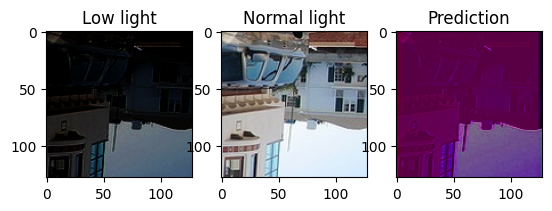

In [5]:
# Show prediction before training
first_ll, first_nl = next(data_loader)
first_nl_pred = model.apply({"params": params}, first_ll)
print("Before training:")
print("PSNR:", np.mean(psnr(first_nl, first_nl_pred)))
print("SSIM:", np.mean(ssim(first_nl, first_nl_pred)))

# Plot the first_ll and first_nl
import matplotlib.pyplot as plt

plt.subplot(1, 3, 1)
plt.imshow(first_ll[0])
plt.title("Low light")
plt.subplot(1, 3, 2)
plt.imshow(first_nl[0])
plt.title("Normal light")
plt.subplot(1, 3, 3)
plt.imshow(first_nl_pred[0])
plt.title("Prediction")
plt.show()

In [6]:
for epoch in range(10):
    for ll, nl in data_loader:
        opt_state, state, _, loss = update_step(
            model.apply, ll, nl, opt_state, params, state, tx
        )
        print(loss)

ValueError: axis 3 is out of bounds for array of dimension 3

In [ ]:
#After 10 epochs
trained_pred = model.apply({"params": params}, first_ll)
print("Before training:")
print("PSNR:", np.mean(psnr(first_nl, trained_pred)))
print("SSIM:", np.mean(ssim(first_nl, trained_pred)))

# Plot the first_ll and first_nl
import matplotlib.pyplot as plt

plt.subplot(1, 3, 1)
plt.imshow(first_ll[0])
plt.title("Low light")
plt.subplot(1, 3, 2)
plt.imshow(first_nl[0])
plt.title("Normal light")
plt.subplot(1, 3, 3)
plt.imshow(trained_pred[0])
plt.title("Prediction")
plt.show()